In [3]:
from ipp_toolkit.experiments.comparing_ipp_approaches import compare_planners
from ipp_toolkit.planners.diversity_planner import BatchDiversityPlanner
from ipp_toolkit.planners.masked_planner import RandomMaskedPlanner
from ipp_toolkit.data.domain_data import AIIRAGreennessRegresssionData
from ipp_toolkit.predictors.uncertain_predictors import GaussianProcessRegression
from ipp_toolkit.predictors.masked_image_predictor import UncertainMaskedLabeledImagePredictor


FileNotFoundError: [Errno 2] No such file or directory: 'vis/iterative_exp/final_values.png'

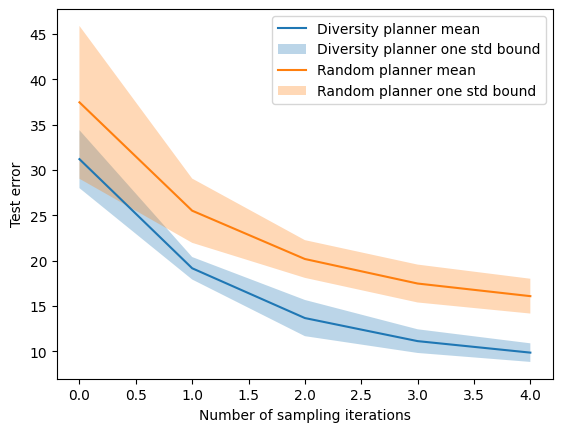

In [4]:
# Define the constants
N_CANDIDATE_LOCATIONS_DIVERSITY = 200
VIS_PLAN = False
N_TRIALS = 5
N_FLIGHTS = 5

# Create the dataset
data = AIIRAGreennessRegresssionData()

# Create your different planners
planners = [
    BatchDiversityPlanner(
        data, n_candidate_locations=N_CANDIDATE_LOCATIONS_DIVERSITY
    ),
    RandomMaskedPlanner(data),
]
# Name them for visualization later
planner_names = ["Diversity planner", "Random planner"]
# Add planner-specific keyword arguments
planner_kwargs = [{"vis": VIS_PLAN}, {"vis": VIS_PLAN}]
# Create a prediction model 
model = GaussianProcessRegression()
# Create a gridded predictor
predictor = UncertainMaskedLabeledImagePredictor(data, model, classification_task=data.is_classification_dataset())

# Run the comparison
compare_planners(
    planners=planners,
    predictor=predictor,
    each_planners_kwargs=planner_kwargs,
    planner_names=planner_names,
    data_manager=data,
    n_trials=N_TRIALS,
    n_flights=N_FLIGHTS,
)